In [1]:
import os
import json
import redis
import pandas as pd 
import matplotlib.pyplot as plt

FILENAME_CSV = "../src/monitoring.csv"

num_packets = {
    "sample.pcap": 88,
    "test_1.pcap": 7707,
    "test_2.pcap": 19731
}

# Loading Data from Redis

In [26]:
# Load & Format the data from Redis
data_used = "test_2.pcap"
numb_of_packets = num_packets[data_used]

# Redis connection details
redis_host = "localhost"
redis_port = 6379
redis_db = 1
redis_key = "monitoring"

r = redis.StrictRedis(host=redis_host, port=redis_port, db=redis_db, decode_responses=True)

raw_data = r.lrange(redis_key, 0, -1)
print(f"Fetched {len(raw_data)} records from Redis.")

data_list = [json.loads(x) for x in raw_data]
df = pd.DataFrame(data_list)

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['elapsed_time'] = pd.to_numeric(df['elapsed_time'])
df['cpu_usage'] = pd.to_numeric(df['cpu_usage'])
df['ram_usage'] = pd.to_numeric(df['ram_usage'])
df['test_file'] = data_used
df['numb_of_packets'] = numb_of_packets

Fetched 22 records from Redis.


In [27]:
# Save data to CSV

if os.path.exists(FILENAME_CSV):
    df_existing = pd.read_csv(FILENAME_CSV, parse_dates=['timestamp'])
    df_combined = pd.concat([df_existing, df], ignore_index=True)
    print(f"Existing data loaded. Appending {len(df)} new records.")
else:
    df_combined = df.copy()
    print(f"No existing data found. Creating new dataset with {len(df)} records.")


df_combined.to_csv(FILENAME_CSV, index=False)
print(f"Data saved to {FILENAME_CSV}")


Existing data loaded. Appending 22 new records.
Data saved to ../src/monitoring.csv


In [28]:
# Clean up Redis
r.delete(redis_key)
print(f"Redis key '{redis_key}' has been deleted.")

Redis key 'monitoring' has been deleted.


# Plotting

In [32]:
# Loads data
df = pd.read_csv(FILENAME_CSV)

groups = df.groupby('test_file')

df_list = [group for _, group in groups]
df1, df2, df3 = df_list  # Unpack into variables

In [35]:
# Calculate average parameters
def print_test_results(test_df, test_number, pcap_key, code_areas=["MDL", "HRS"]):
    """
    Print average CPU, RAM, elapsed time, and throughput for each specified code area in a given test.
    
    Parameters:
        test_df (DataFrame): DataFrame for the current test.
        test_number (int or str): Identifier for the test.
        pcap_key (str): Key to access the corresponding number of packets from the num_packets dict.
        code_areas (list): List of code area labels to process.
    """
    print(f"TEST {test_number}")
    for area in code_areas:
        # Filter the DataFrame for the current code area
        area_df = test_df[test_df["code_area"] == area]
        
        # Calculate metrics
        cpu_mean = area_df["cpu_usage"].mean()
        ram_mean = area_df["ram_usage"].mean()
        elapsed_time_mean = area_df["elapsed_time"].mean()
        throughput = elapsed_time_mean / num_packets[pcap_key]
        
        # Print results with formatted output
        print(f"Average CPU usage for {area}: {cpu_mean:.4f}%")
        print(f"Average RAM usage for {area}: {ram_mean:.4f} MB")
        print(f"Average elapsed time for {area}: {elapsed_time_mean:.4f} s")
        print(f"Throughput for {area}: {throughput:.4f} pps\n")
    
    print("-" * 60)


code_areas = ["MDL", "HRS", "E2P", "P2C"]
packet_keys = [num_packets["sample.pcap"], num_packets["test_1.pcap"], num_packets["test_2.pcap"]]

print_test_results(df1, 1, "sample.pcap", code_areas)
print_test_results(df2, 2, "test_1.pcap", code_areas)
print_test_results(df3, 3, "test_2.pcap", code_areas)


TEST 1
Average CPU usage for MDL: 6.5790%
Average RAM usage for MDL: 665.9016 MB
Average elapsed time for MDL: 0.4647 s
Throughput for MDL: 0.0053 pps

Average CPU usage for HRS: 4.3074%
Average RAM usage for HRS: 665.9016 MB
Average elapsed time for HRS: 1.4784 s
Throughput for HRS: 0.0168 pps

Average CPU usage for E2P: 5.9841%
Average RAM usage for E2P: 640.7120 MB
Average elapsed time for E2P: 0.0119 s
Throughput for E2P: 0.0001 pps

Average CPU usage for P2C: 2.2233%
Average RAM usage for P2C: 641.2681 MB
Average elapsed time for P2C: 0.7634 s
Throughput for P2C: 0.0087 pps

------------------------------------------------------------
TEST 2
Average CPU usage for MDL: 10.3108%
Average RAM usage for MDL: 759.3288 MB
Average elapsed time for MDL: 1.0917 s
Throughput for MDL: 0.0001 pps

Average CPU usage for HRS: 1.0392%
Average RAM usage for HRS: 735.0057 MB
Average elapsed time for HRS: 24.1055 s
Throughput for HRS: 0.0031 pps

Average CPU usage for E2P: 6.2273%
Average RAM usage 

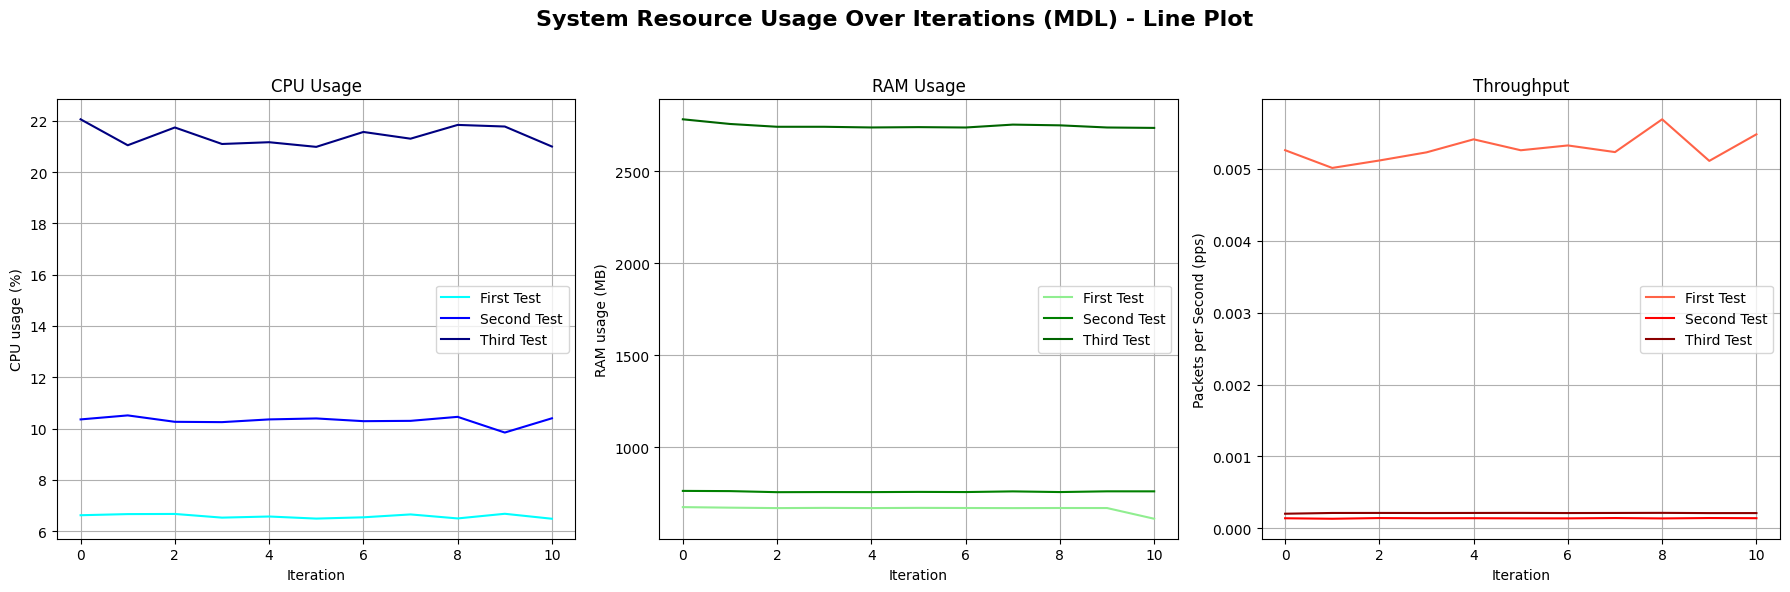

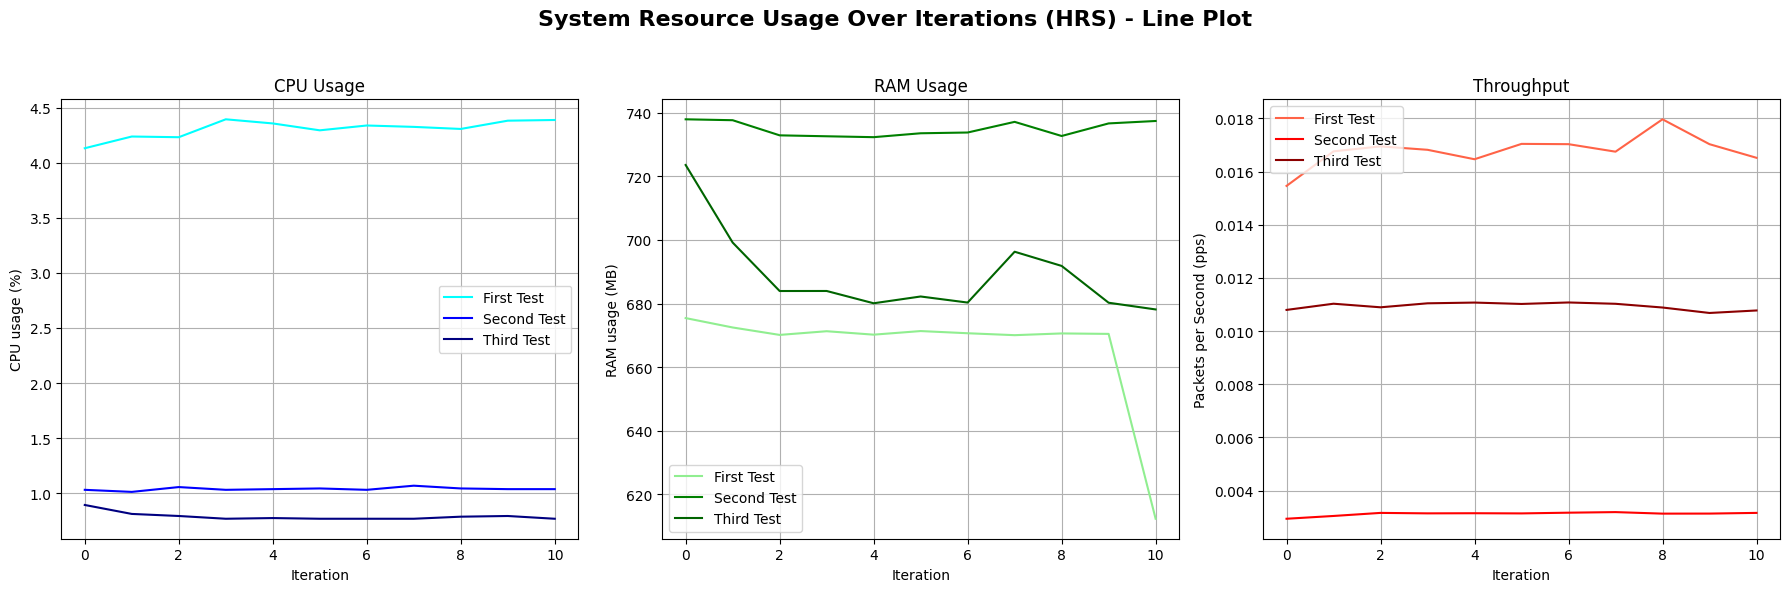

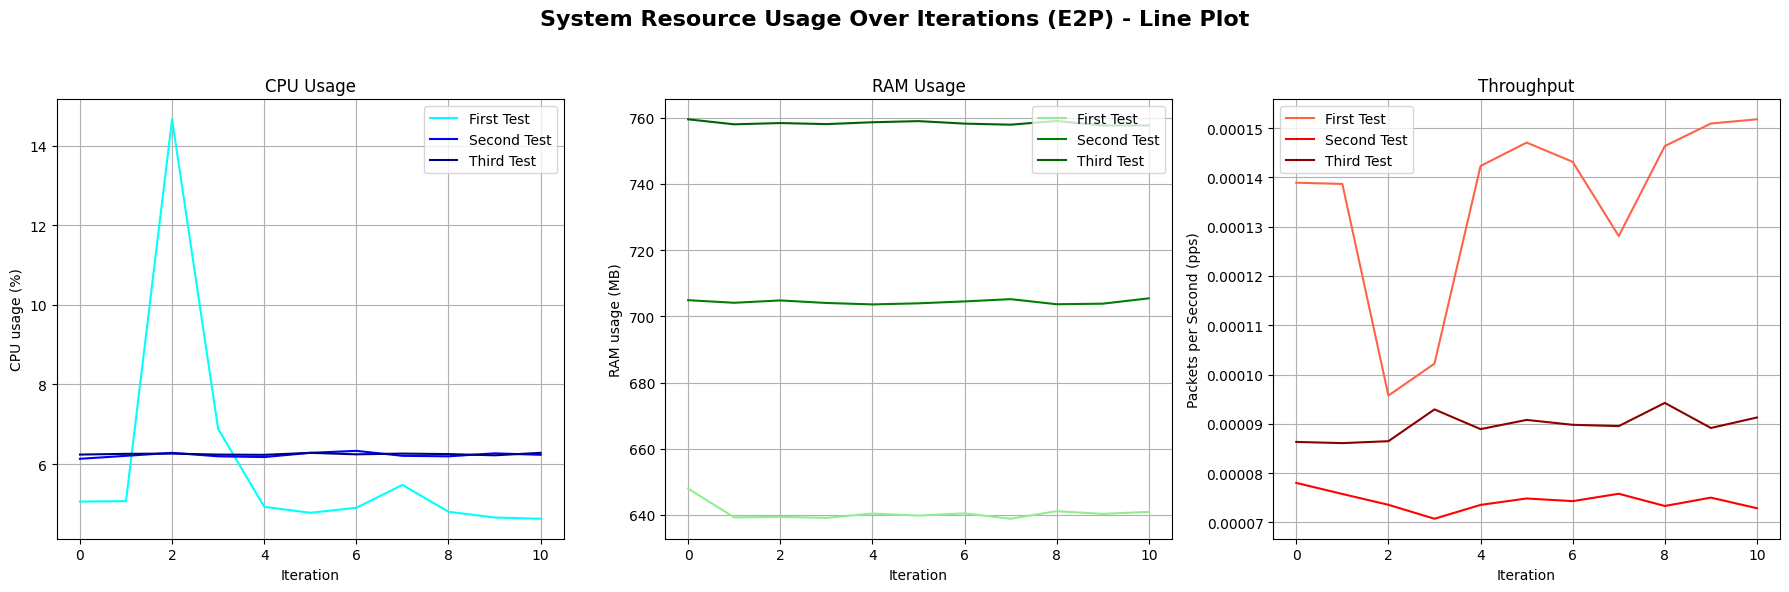

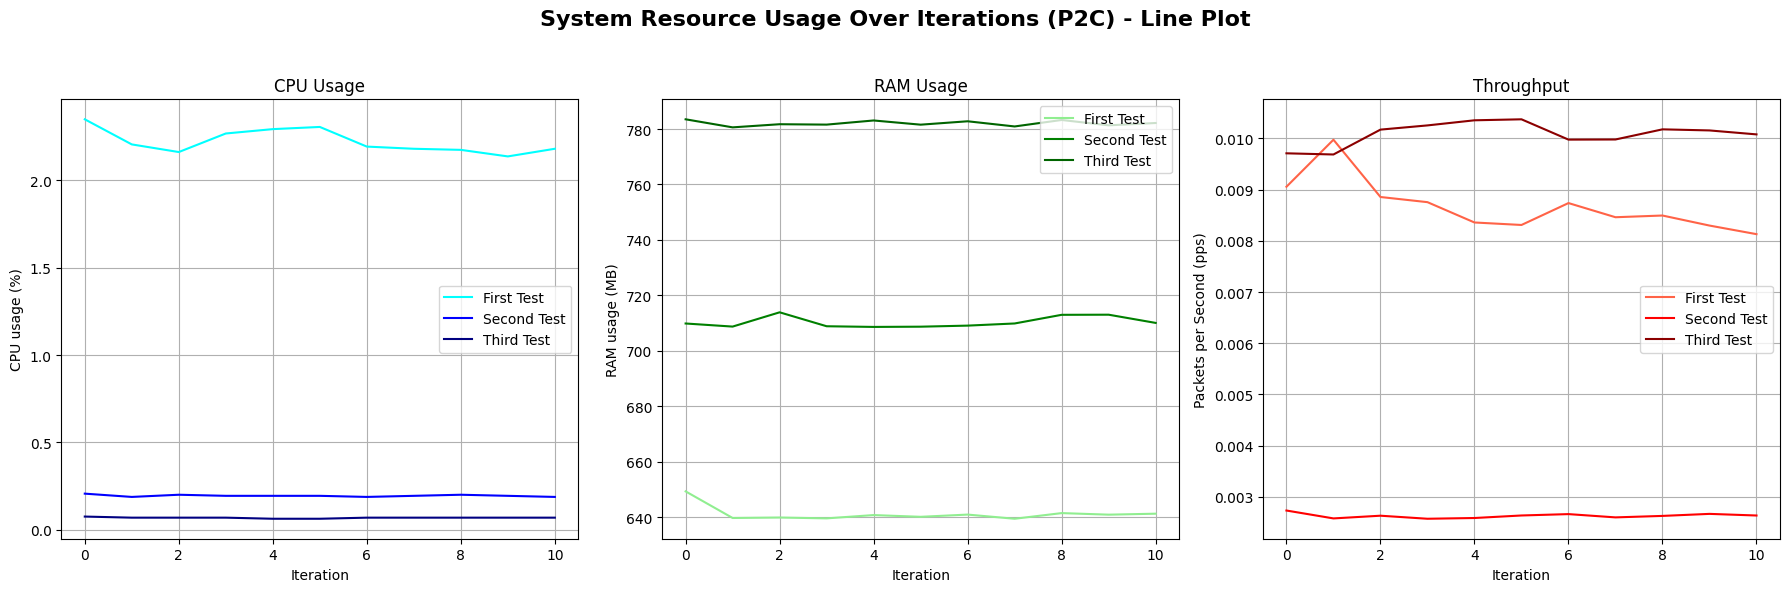

In [36]:
# Line Plot the data

def plot_line_metrics(code_area, dfs, packet_keys, test_labels=["First Test", "Second Test", "Third Test"]):
    """
    Create line plots for CPU, RAM, and Throughput for a given code_area.
    
    Parameters:
      - code_area (str): The code area filter (e.g., "MDL" or "HRS").
      - dfs (list): List of DataFrames for each test.
      - packet_keys (list): List of keys to retrieve packet values for throughput computation.
      - test_labels (list): Labels for each test.
    """
    # Define colors for each test and metric
    colors_cpu = ['cyan', 'blue', 'navy']
    colors_ram = ['lightgreen', 'green', 'darkgreen']
    colors_th = ['tomato', 'red', 'darkred']
    
    fig = plt.figure(figsize=(18, 6))
    fig.suptitle(f"System Resource Usage Over Iterations ({code_area}) - Line Plot", 
                 fontsize=16, fontweight='bold')
    
    # Subplot 1: CPU Usage
    ax1 = plt.subplot(1, 3, 1)
    for i, df in enumerate(dfs):
        df_filtered = df[df["code_area"] == code_area]
        ax1.plot(range(len(df_filtered)), df_filtered['cpu_usage'], label=test_labels[i], color=colors_cpu[i])
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('CPU usage (%)')
    ax1.set_title('CPU Usage')
    ax1.legend()
    ax1.grid(True)
    
    # Subplot 2: RAM Usage
    ax2 = plt.subplot(1, 3, 2)
    for i, df in enumerate(dfs):
        df_filtered = df[df["code_area"] == code_area]
        ax2.plot(range(len(df_filtered)), df_filtered['ram_usage'], label=test_labels[i], color=colors_ram[i])
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('RAM usage (MB)')
    ax2.set_title('RAM Usage')
    ax2.legend()
    ax2.grid(True)
    
    # Subplot 3: Throughput (Packets per Second)
    ax3 = plt.subplot(1, 3, 3)
    for i, df in enumerate(dfs):
        df_filtered = df[df["code_area"] == code_area]
        throughput = df_filtered['elapsed_time'].div(packet_keys[i])
        ax3.plot(range(len(df_filtered)), throughput, label=test_labels[i], color=colors_th[i])
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Packets per Second (pps)')
    ax3.set_title('Throughput')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_line_metrics("MDL", df_list, packet_keys)
plot_line_metrics("HRS", df_list, packet_keys)
plot_line_metrics("E2P", df_list, packet_keys)
plot_line_metrics("P2C", df_list, packet_keys)

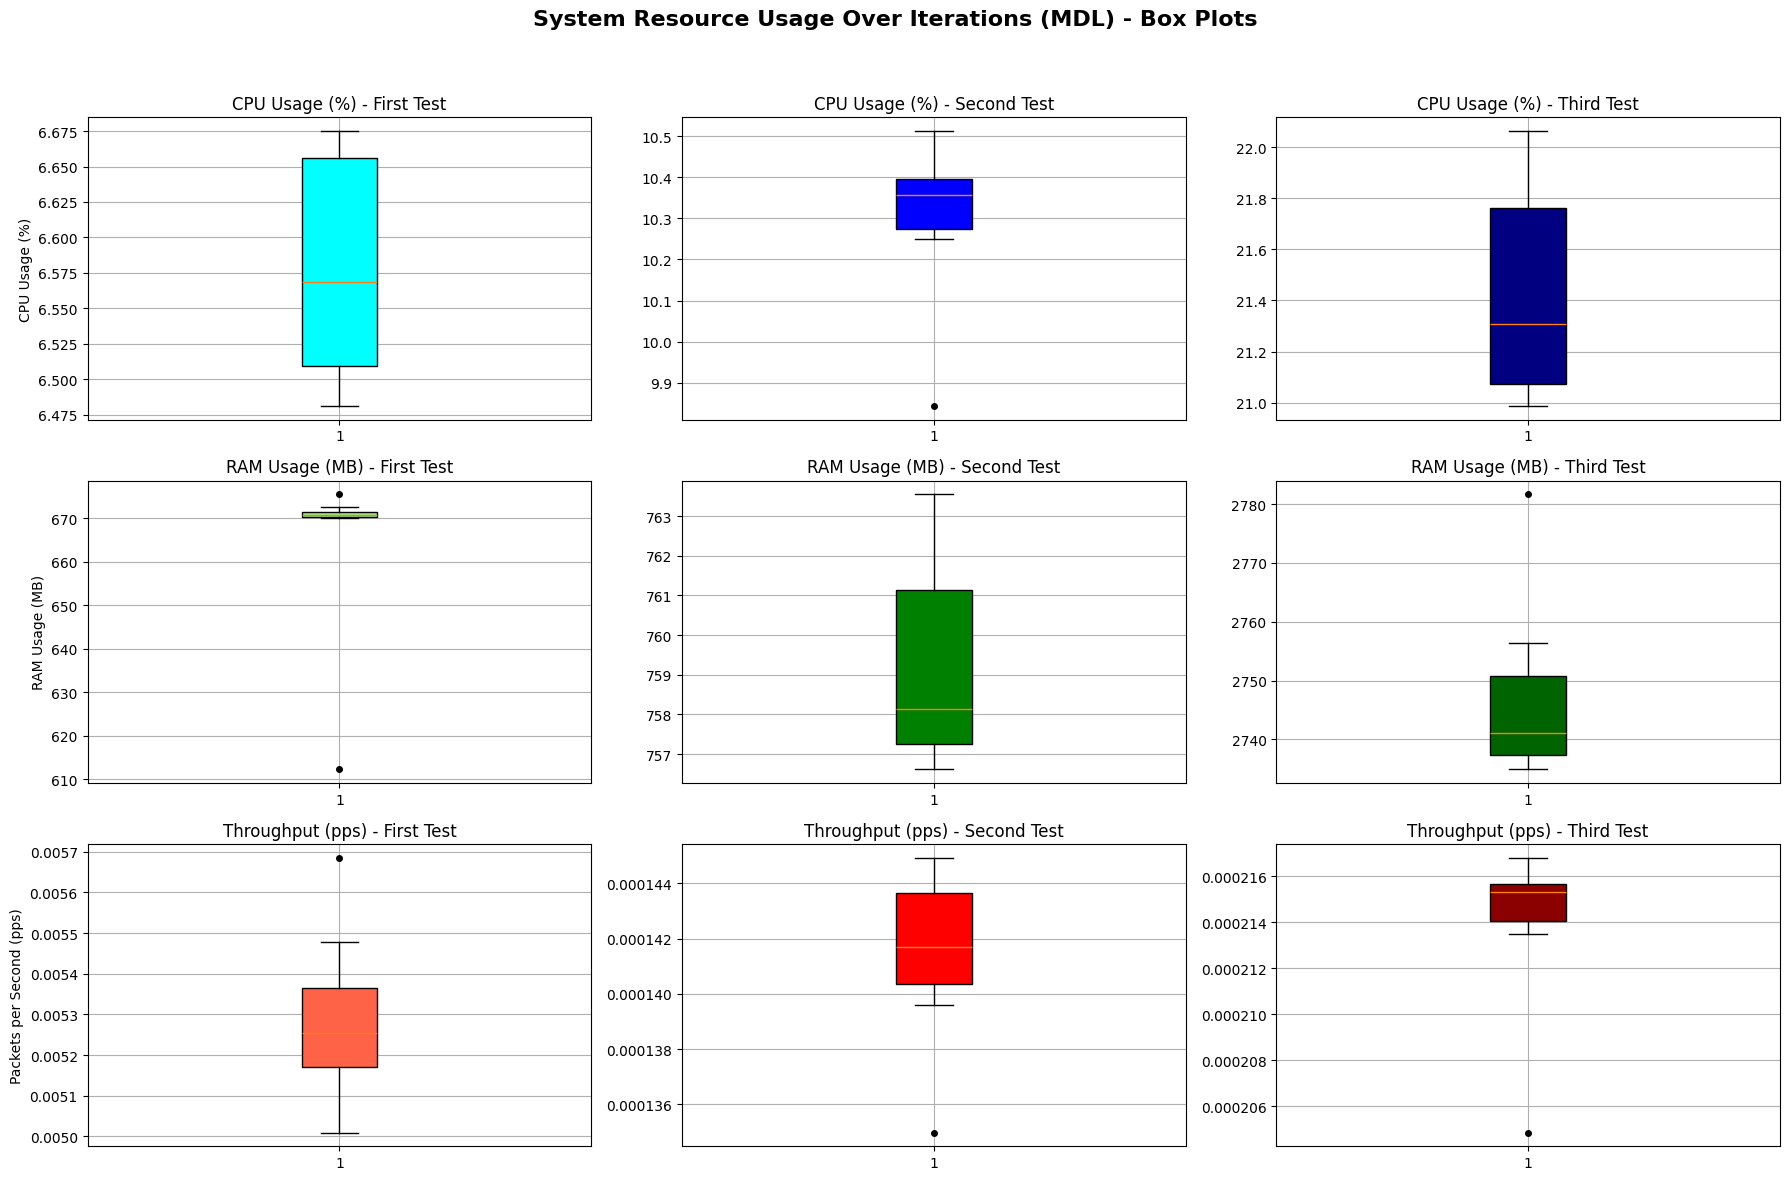

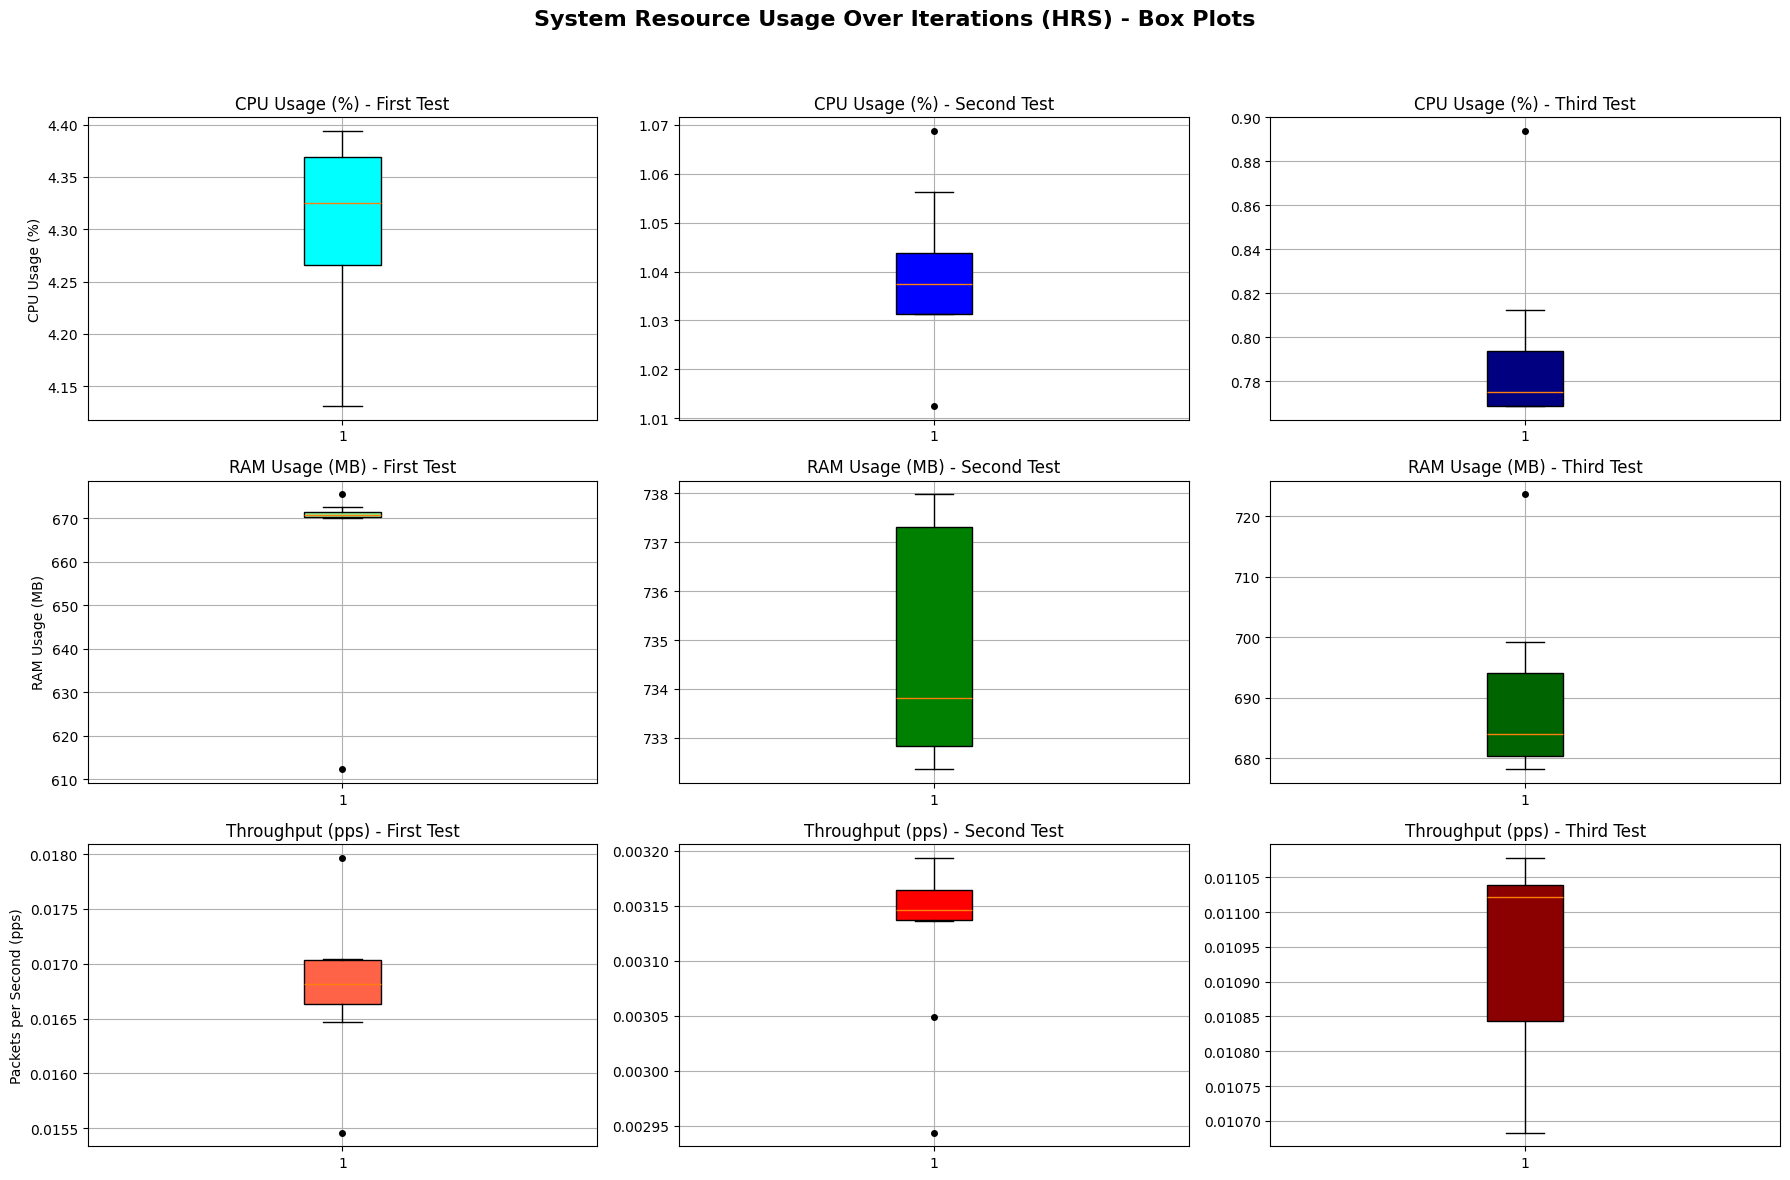

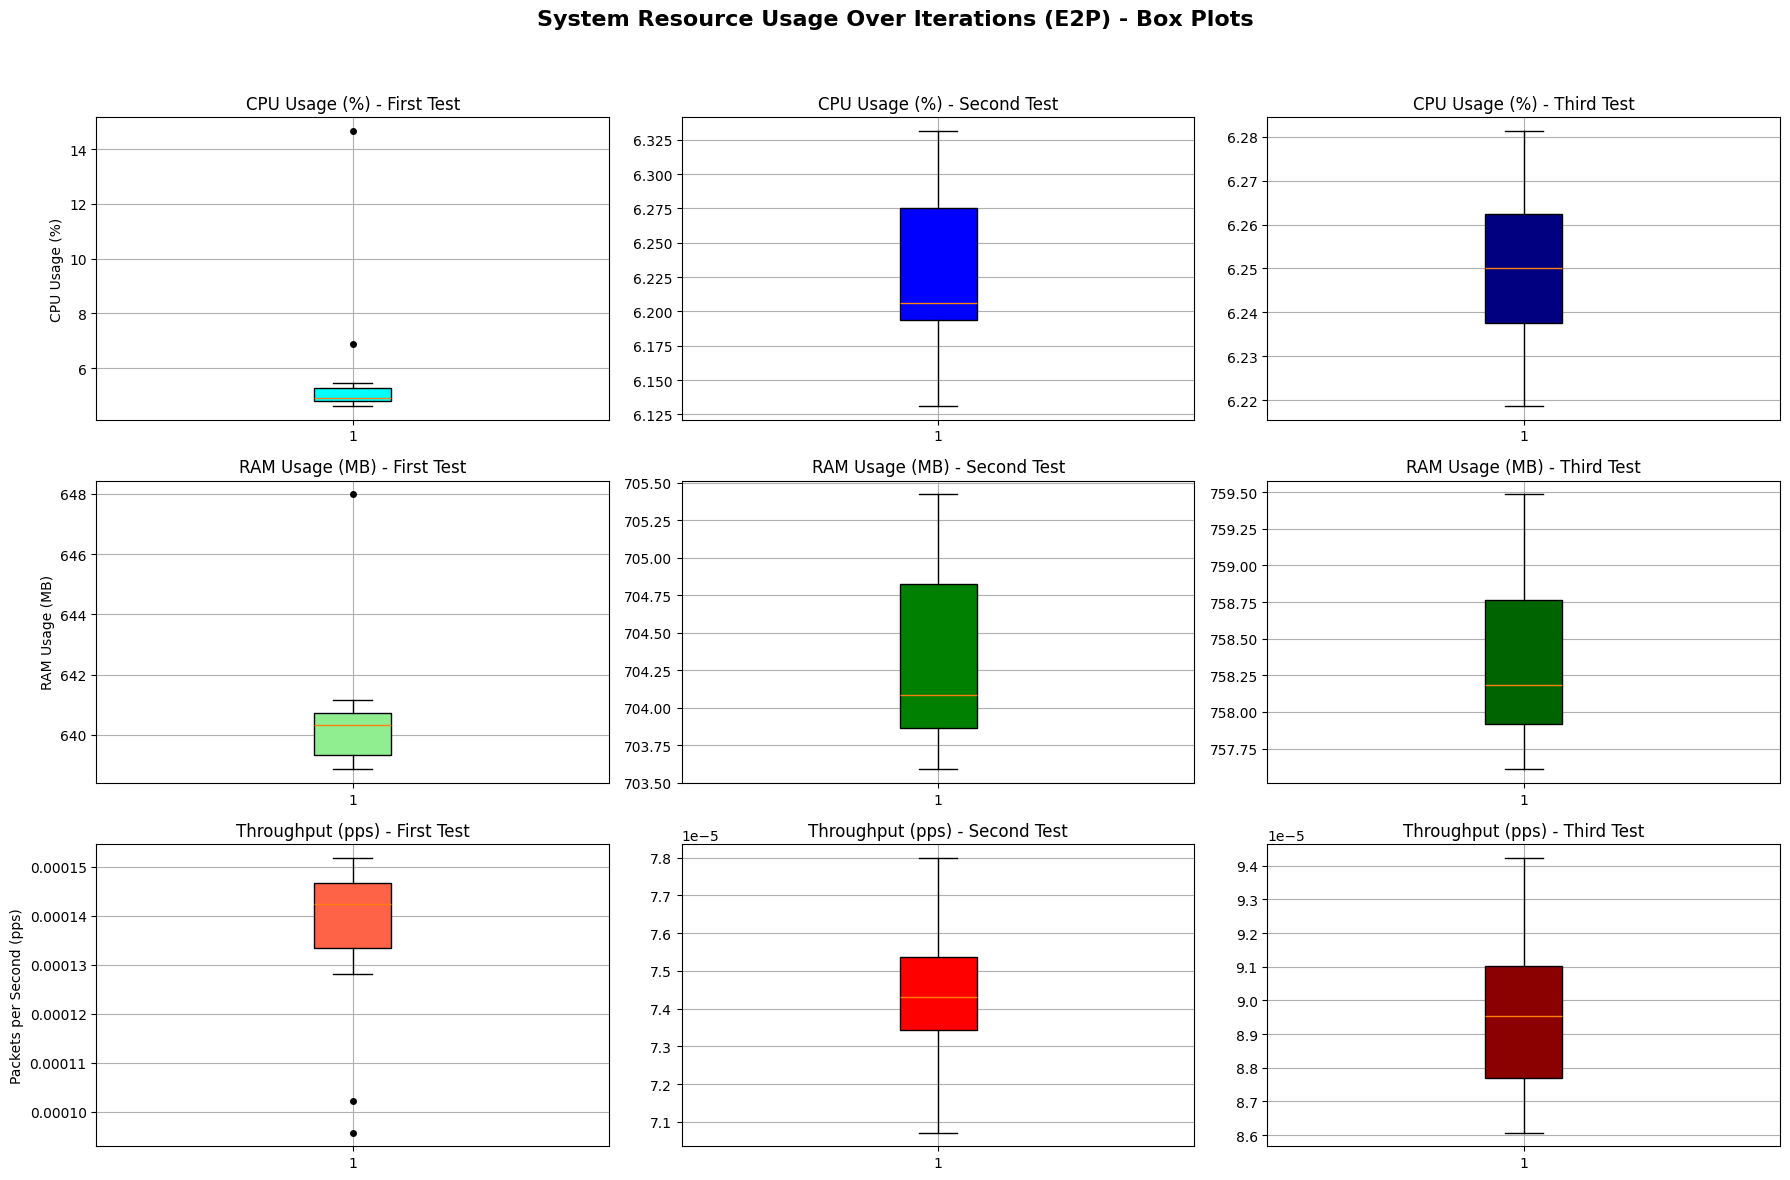

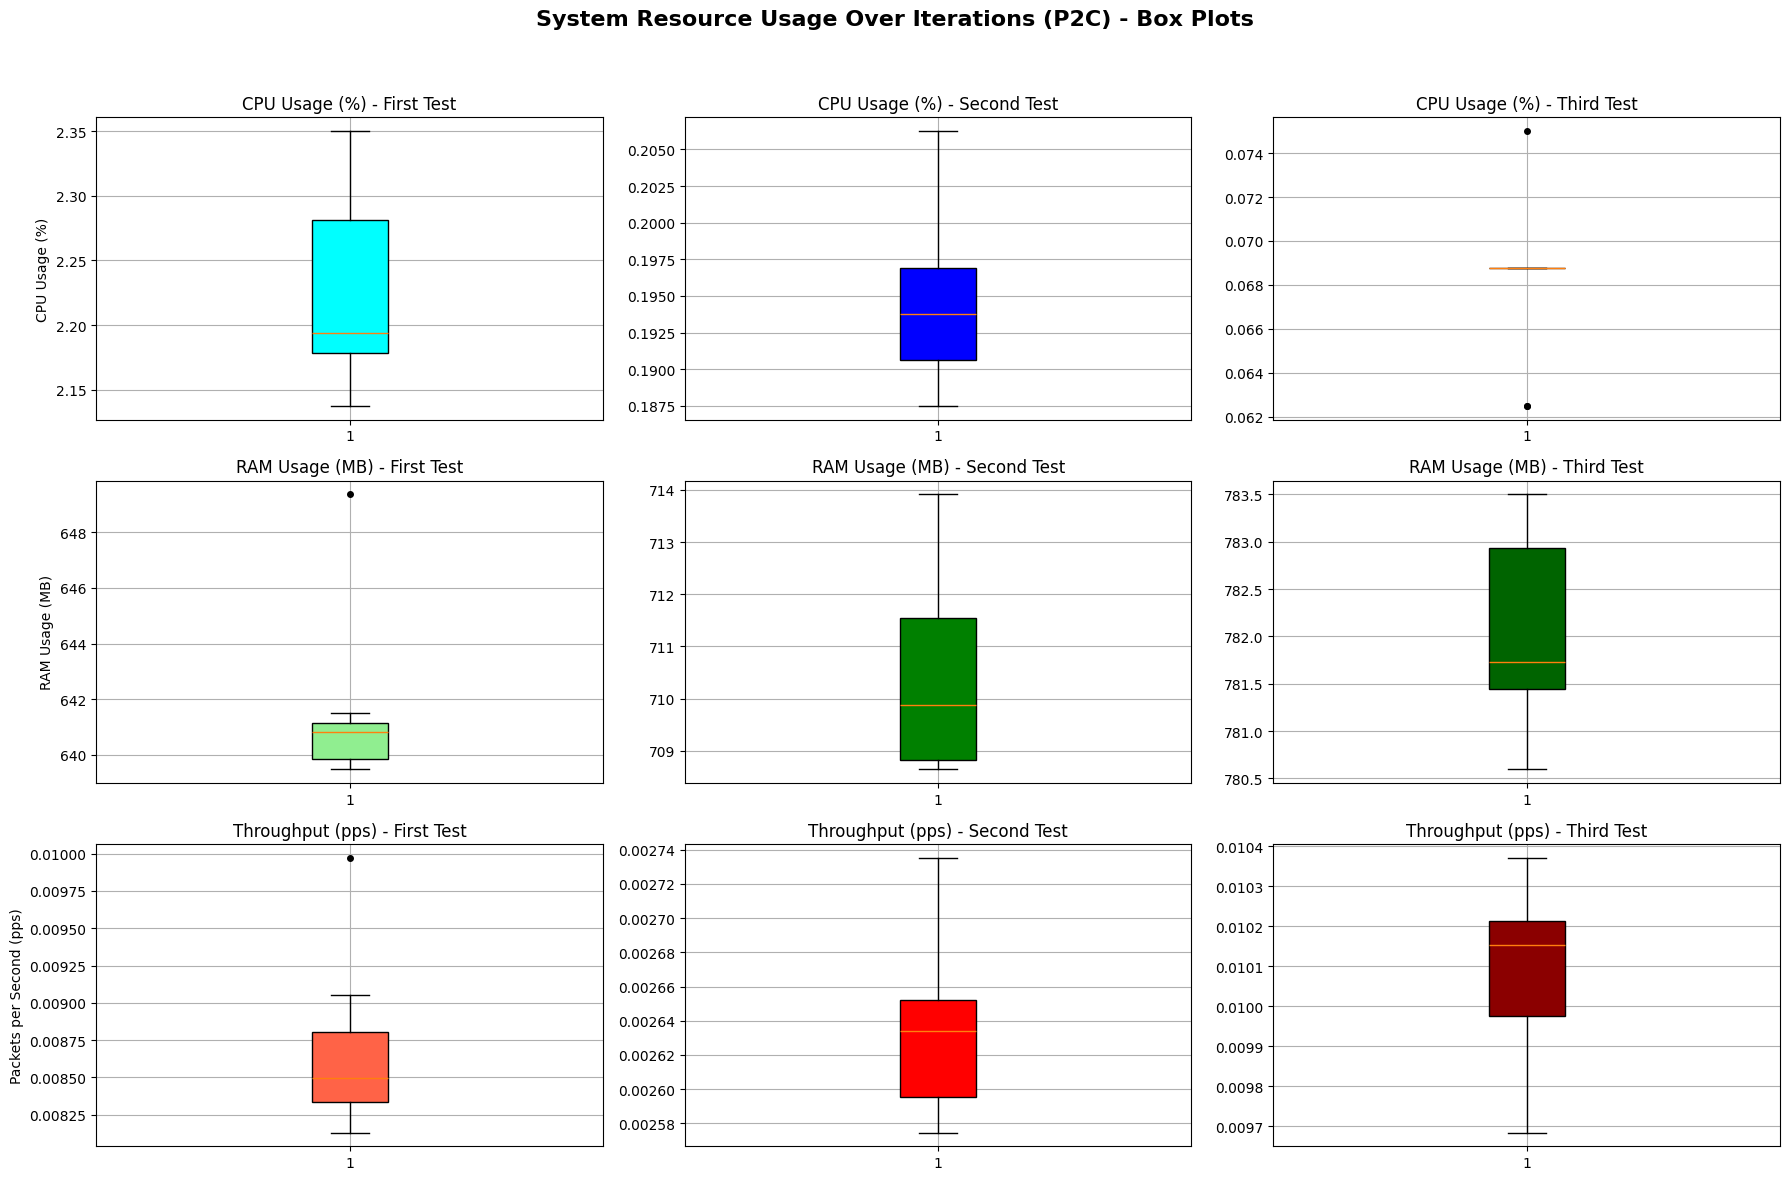

In [37]:
# Box Plot the data

def plot_box_metrics(code_area, dfs, packet_keys, test_labels=["First Test", "Second Test", "Third Test"]):
    """
    Create a 3x3 grid of box plots for CPU, RAM, and Throughput for a given code_area.
    
    Parameters:
      - code_area (str): The code area filter (e.g., "MDL" or "HRS").
      - dfs (list): List of DataFrames for each test.
      - packet_keys (list): List of keys for throughput calculation.
      - test_labels (list): Labels for each test.
    """
    # Define colors for each test and metric
    colors_cpu = ['cyan', 'blue', 'navy']
    colors_ram = ['lightgreen', 'green', 'darkgreen']
    colors_th = ['tomato', 'red', 'darkred']
    
    # Prepare metric data for each test
    cpu_data = [df[df["code_area"] == code_area]['cpu_usage'] for df in dfs]
    ram_data = [df[df["code_area"] == code_area]['ram_usage'] for df in dfs]
    th_data = [
        df[df["code_area"] == code_area]['elapsed_time'].div(packet_keys[i])
        for i, df in enumerate(dfs)
    ]
    
    # Create a 3x3 figure grid:
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
    fig.suptitle(f"System Resource Usage Over Iterations ({code_area}) - Box Plots", 
                 fontsize=16, fontweight='bold')
    
    # Row 1: CPU Usage
    for i in range(len(dfs)):
        bp = axes[0, i].boxplot(cpu_data[i], patch_artist=True,
                                flierprops=dict(marker='o', markerfacecolor='black', markersize=4))
        axes[0, i].set_title(f"CPU Usage (%) - {test_labels[i]}")
        if i == 0:
            axes[0, i].set_ylabel("CPU Usage (%)")
        axes[0, i].grid(True)
        for patch in bp['boxes']:
            patch.set_facecolor(colors_cpu[i])
    
    # Row 2: RAM Usage
    for i in range(len(dfs)):
        bp = axes[1, i].boxplot(ram_data[i], patch_artist=True,
                                flierprops=dict(marker='o', markerfacecolor='black', markersize=4))
        axes[1, i].set_title(f"RAM Usage (MB) - {test_labels[i]}")
        if i == 0:
            axes[1, i].set_ylabel("RAM Usage (MB)")
        axes[1, i].grid(True)
        for patch in bp['boxes']:
            patch.set_facecolor(colors_ram[i])
    
    # Row 3: Throughput
    for i in range(len(dfs)):
        bp = axes[2, i].boxplot(th_data[i], patch_artist=True,
                                flierprops=dict(marker='o', markerfacecolor='black', markersize=4))
        axes[2, i].set_title(f"Throughput (pps) - {test_labels[i]}")
        if i == 0:
            axes[2, i].set_ylabel("Packets per Second (pps)")
        axes[2, i].grid(True)
        for patch in bp['boxes']:
            patch.set_facecolor(colors_th[i])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


plot_box_metrics("MDL", df_list, packet_keys)
plot_box_metrics("HRS", df_list, packet_keys)
plot_box_metrics("E2P", df_list, packet_keys)
plot_box_metrics("P2C", df_list, packet_keys)
